# EE376 Card Game

This notebook defines an agent to play the imperfect information card game. It runs on Python 2.7.

### Contents:
1. Imports
1. Core
    1. Agent Base Class
    1. Helper Functions
1. Specific Agents
    1. Greedy Agent
    1. Optimal Agent
    1. Information Agent
1. Sweeps
    1. Information Agent vs $\gamma$
    1. Greedy, Optimal, Info Agent EV vs Initial Deck
1. Outreach
    1. Interactive CPU
    1. Record of Results

## Imports

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys, pdb, pickle
from multiprocessing import Pool
from fractions import Fraction
import time, math
from copy import deepcopy
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Agent Base Class

Use this as the base class for other agents, such as GreedyAgent.

In [2]:
class Agent(object):
    def __init__(self, initial=None):
        if initial: self.reset(initial)
    
    def reset(self, initial):
        self.initial = initial
        self.group_num = len(initial)
        self.size = sum(self.initial)
        self.states = {self.initial:Fraction(1)}
        self.correct = 0
        self.group_prob = [ Fraction(x, sum(self.initial)) for x in self.initial ]
    
    def set_composition(self, composition):
        example_element = composition.keys()[0]
        self.group_num = len(example_element)
        self.size = sum(example_element)
        self.states = composition
        self.correct = 0
        self.update_group_prob()
        
    def serialize(self):
        return 'x'.join(map(str, self.initial)) + ' ' + ' '.join(sorted(['|'.join(map(str, k)) + ':%s'%str(v) for k,v in self.states.iteritems()]))
    
    def get_state_entropy(self, total=False):
        entropy = 0.0
        for k,v in self.states.iteritems():
            micro_per_macro = math.factorial(sum(k)) / np.prod(map(math.factorial, k)) if total else 1.0
            entropy -= v * np.log2(v / micro_per_macro)
        return entropy
    
    def make_guess(self):
        raise NotImplementedError('This method must be implemented.')
    
    def ev(self, memo=None):
        if self.size <= 0: return 0
        if memo is None: memo = {}
        serial = self.serialize()
        if serial in memo: return memo[serial]
        guess = self.make_guess()
        
        copy0 = deepcopy(self)
        if copy0.update_state(guess, False): ev0 = copy0.ev(memo)
        else: ev0 = 0
        copy1 = deepcopy(self)
        if copy1.update_state(guess,  True): ev1 = copy1.ev(memo) + 1
        else: ev1 = 0
        
        ev = (1 - self.group_prob[guess]) * ev0 + self.group_prob[guess] * ev1
        memo[serial] = ev
        return ev
    
    def update_group_prob(self):
        if self.size:
            self.group_prob = [0] * self.group_num
            for k,v in self.states.iteritems():
                for i in range(len(k)):
                    self.group_prob[i] += v * k[i] / self.size
            if sum(self.group_prob) != 1:
                print('Warning: sum of group probabilities %f != 1.0'%sum(self.group_prob))
    
    def update_state(self, guess, correct):
        self.correct += correct
        self.size -= 1
        next_states = {}
        for k,v in self.states.iteritems():
            if correct and k[guess]:
                bayes = Fraction(k[guess], sum(k)) * v / self.group_prob[guess]
                kl = list(k)
                kl[guess] -= 1
                kl = tuple(kl)
                if kl not in next_states: next_states[kl] = Fraction(0)
                next_states[kl] += bayes
            if not correct and sum(k) - k[guess]:
                bayes0 = (1 - Fraction(k[guess], sum(k))) * v / (1 - self.group_prob[guess])
                for other in range(self.group_num):
                    if other == guess or not k[other]: continue
                    bayes = bayes0 * Fraction(k[other], sum(k) - k[guess])
                    kl = list(k)
                    kl[other] -= 1
                    kl = tuple(kl)
                    if kl not in next_states: next_states[kl] = Fraction(0)
                    next_states[kl] += bayes
        self.states = next_states
        if not len(self.states): return False
        if sum(self.states.values()) != 1:
            print('Warning: sum of state probabilities %f != 1.0'%sum(self.states.values()))
        self.update_group_prob()
        return True
    
    def run(self, deck):
        self.reset(tuple(np.bincount(deck)))
        for card in deck:
            guess = self.make_guess()
            self.update_state(guess, guess==card)
        return self.correct

## Helper Functions

1. generate_all_decks: given a compressed representation of the composition of cards, generates a list of all decks.
2. deck_ev: computes the expected number of correct guesses for a given agent, given a compressed representation of the composition of cards.

In [3]:
def generate_all_decks(initial):
    all_decks = []
    if sum(initial) == 1:
        for i in range(len(initial)):
            if initial[i] > 0: return [[i]]
    for i in range(len(initial)):
        if initial[i] > 0:
            initial[i] -= 1
            recur_decks = generate_all_decks(initial)
            initial[i] += 1
            all_decks += [[i] + deck for deck in recur_decks]
    return all_decks
all_decks = generate_all_decks([3,3,3])
print('Number of Unique Decks:', len(all_decks))

from functools import partial
def f(l, a):
    return a.run(l)

def chunks(l, n):
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

def deck_ev(agent, initial, verbose=True, **kwargs):
    nproc = 8
    p = Pool(nproc)
    batch_size = 2 * nproc
    a = agent(**kwargs)
    
    all_decks = generate_all_decks(list(initial))
    correct_guesses = []
    for idx, decks in enumerate(chunks(all_decks, batch_size)):
        correct_guesses += p.map(partial(f, a=a), decks)
        if verbose:
            print('\rOn deck %s (%04d/%04d) | EV %.6f'%(''.join(map(str, decks[-1])), min((idx+1)*batch_size, len(all_decks)), len(all_decks), np.mean(correct_guesses)), end='')
            sys.stdout.flush()
    if verbose:
        print()
    p.terminate()
    return np.mean(correct_guesses)

Number of Unique Decks: 1680


## Greedy Agent

Selects the card maximizing unconditioned-probability over all states.

In [4]:
class GreedyAgent(Agent):
    def __init__(self, **kwargs):
        super(GreedyAgent, self).__init__(**kwargs)
    def reset(self, initial):
        super(GreedyAgent, self).reset(initial)
    def make_guess(self):
        return np.argmax(self.group_prob)

# Test Script
a = GreedyAgent()
a.reset((3,3,3))
guess1 = a.make_guess()
a.update_state(guess1, True)
guess2 = a.make_guess()
a.update_state(guess2, False)
print('First guess: %d | Second guess: %d | States:'%(guess1, guess2), a.states)

First guess: 0 | Second guess: 1 | States: {(2, 3, 2): Fraction(3, 5), (1, 3, 3): Fraction(2, 5)}


In [5]:
ev = deck_ev(GreedyAgent, (3,3,3))
print('Expected Correct Guesses: %.15f'%ev)

On deck 222111000 (1680/1680) | EV 4.241071
Expected Correct Guesses: 4.241071428571429


In [6]:
t0 = time.time()
initial = (3,3,3)
ev = GreedyAgent(initial=(3,3,3)).ev()
print(initial, '=> EV: %.15f (%s)'%(ev, str(ev)))
print('Took %.3f seconds'%(time.time() - t0))

(3, 3, 3) => EV: 4.241071428571429 (475/112)
Took 0.231 seconds


## Optimal Agent

Picks choices optimally by simulating itself recursively for each possible choice.

In [7]:
class OptimalAgent(Agent):
    def __init__(self, **kwargs):
        super(OptimalAgent, self).__init__(**kwargs)
        
    def reset(self, initial):
        super(OptimalAgent, self).reset(initial)
        
    def expected_correct(self, guess, memo, verbose=False):
        if self.size <= 0: return 0
        
        copy0 = OptimalAgent(initial=self.initial)
        copy0.set_composition(deepcopy(self.states))
        if copy0.update_state(guess, False): ev0 = copy0.make_guess_aux(memo)[1]
        else: ev0 = 0
        
        copy1 = OptimalAgent(initial=self.initial)
        copy1.set_composition(deepcopy(self.states))
        if copy1.update_state(guess,  True): ev1 = copy1.make_guess_aux(memo)[1] + 1
        else: ev1 = 0
            
        ev = (1 - self.group_prob[guess]) * ev0 + self.group_prob[guess] * ev1
            
        if verbose and self.size == 3:
            print(self.states)
            print('Guess:', guess, ' - ev0:', ev0, ' - ev1:', ev1, ' - ev:', ev)
            
        return ev
    
    def make_guess_aux(self, memo, verbose=False):
        serial = self.serialize()
        if serial in memo: return memo[serial]
        if sum(np.array(self.group_prob) > 0) <= 2:
            pick = np.argmax(self.group_prob)
            ret = (pick, self.expected_correct(pick, memo))
            memo[serial] = ret
            return ret
        best_ev = 0
        best_pick = 0
        for pick in range(self.group_num):
            ev = self.expected_correct(pick, memo, verbose=verbose)
            if ev > best_ev:
                best_ev = ev
                best_pick = pick
        ret = (best_pick, best_ev)
        memo[serial] = ret
        return ret
    
    def ev(self):
        memo = {}
        return self.make_guess_aux(memo)[1]
    
    def make_guess(self, verbose=False):
        memo = {}
        return self.make_guess_aux(memo, verbose=verbose)[0]

# Test Script
a = OptimalAgent()
a.reset((1,1,1))
guess1 = a.make_guess()
a.update_state(guess1, True)
guess2 = a.make_guess()
a.update_state(guess2, False)
print('First guess: %d | Second guess: %d | States:'%(guess1, guess2), a.states)

First guess: 0 | Second guess: 1 | States: {(0, 1, 0): Fraction(1, 1)}


In [8]:
t0 = time.time()
initial = (3,3,3)
ev = OptimalAgent(initial=initial).ev()
print(initial, '=> EV: %.15f (%s)'%(ev, str(ev)))
print('Took %.3f seconds'%(time.time() - t0))

(3, 3, 3) => EV: 4.255357142857143 (2383/560)
Took 4.561 seconds


## Information Agent

Picks the card maximizing the unconditioned probability of being correct, minus `gamma` times the entropy gained by making that choice.

In [9]:
class InfoAgent(Agent):
    def __init__(self, gamma=1e-5, **kwargs):
        super(InfoAgent, self).__init__(**kwargs)
        self.gamma = gamma
    def reset(self, initial):
        super(InfoAgent, self).reset(initial)
    def make_guess(self):
        best_eiv  = 0
        best_pick = 0
        for pick in range(self.group_num):
            copy0 = deepcopy(self)
            copy0.update_state(pick, False)
            ent0 = copy0.get_state_entropy()
            copy1 = deepcopy(self)
            copy1.update_state(pick, True)
            ent1 = copy1.get_state_entropy()
            entropy = (1 - self.group_prob[pick]) * ent0 + self.group_prob[pick] * ent1
            eiv = self.group_prob[pick] - self.gamma * entropy
            if eiv > best_eiv:
                best_eiv = eiv
                best_pick = pick
        return best_pick

# Test Script
a = InfoAgent()
a.reset((3,3,3))
guess1 = a.make_guess()
a.update_state(guess1, True)
guess2 = a.make_guess()
a.update_state(guess2, False)
print('First guess: %d | Second guess: %d | States:'%(guess1, guess2), a.states)

First guess: 0 | Second guess: 1 | States: {(2, 3, 2): Fraction(3, 5), (1, 3, 3): Fraction(2, 5)}


In [10]:
t0 = time.time()
initial = (3,3,3)
ev = InfoAgent(gamma=0.15, initial=(3,3,3)).ev()
print(initial, '=> EV: %.15f (%s)'%(ev, str(ev)))
print('Took %.3f seconds'%(time.time() - t0))

(3, 3, 3) => EV: 4.255357142857143 (2383/560)
Took 0.660 seconds


## Information Agent Sweeps

In [11]:
initial = (3,3,3)
opt_ev = OptimalAgent(initial=initial).ev()
greedy_ev = GreedyAgent(initial=initial).ev()

sweep_vars = np.arange(-50, 50.0001, 1) / 100.0
sweep_evs  = []
for gamma in sweep_vars:
    ev = InfoAgent(gamma=gamma, initial=initial).ev()
    print('Gamma %.1e => EV %.6f'%(gamma, ev))
    sweep_evs.append(ev)
sweep_evs = np.array(sweep_evs)

Gamma -5.0e-01 => EV 3.779762
Gamma -4.9e-01 => EV 3.780952
Gamma -4.8e-01 => EV 3.780952
Gamma -4.7e-01 => EV 3.802381
Gamma -4.6e-01 => EV 3.802381
Gamma -4.5e-01 => EV 3.802381
Gamma -4.4e-01 => EV 3.802381
Gamma -4.3e-01 => EV 3.802381
Gamma -4.2e-01 => EV 3.802381
Gamma -4.1e-01 => EV 3.802381
Gamma -4.0e-01 => EV 3.811310
Gamma -3.9e-01 => EV 3.822024
Gamma -3.8e-01 => EV 3.832738
Gamma -3.7e-01 => EV 3.832738
Gamma -3.6e-01 => EV 3.862500
Gamma -3.5e-01 => EV 3.862500
Gamma -3.4e-01 => EV 3.862500
Gamma -3.3e-01 => EV 3.862500
Gamma -3.2e-01 => EV 3.908333
Gamma -3.1e-01 => EV 3.908333
Gamma -3.0e-01 => EV 3.917857
Gamma -2.9e-01 => EV 3.917857
Gamma -2.8e-01 => EV 3.917857
Gamma -2.7e-01 => EV 3.917857
Gamma -2.6e-01 => EV 3.917857
Gamma -2.5e-01 => EV 3.917857
Gamma -2.4e-01 => EV 4.000000
Gamma -2.3e-01 => EV 4.000000
Gamma -2.2e-01 => EV 4.000000
Gamma -2.1e-01 => EV 4.054762
Gamma -2.0e-01 => EV 4.083333
Gamma -1.9e-01 => EV 4.083333
Gamma -1.8e-01 => EV 4.083333
Gamma -1.7

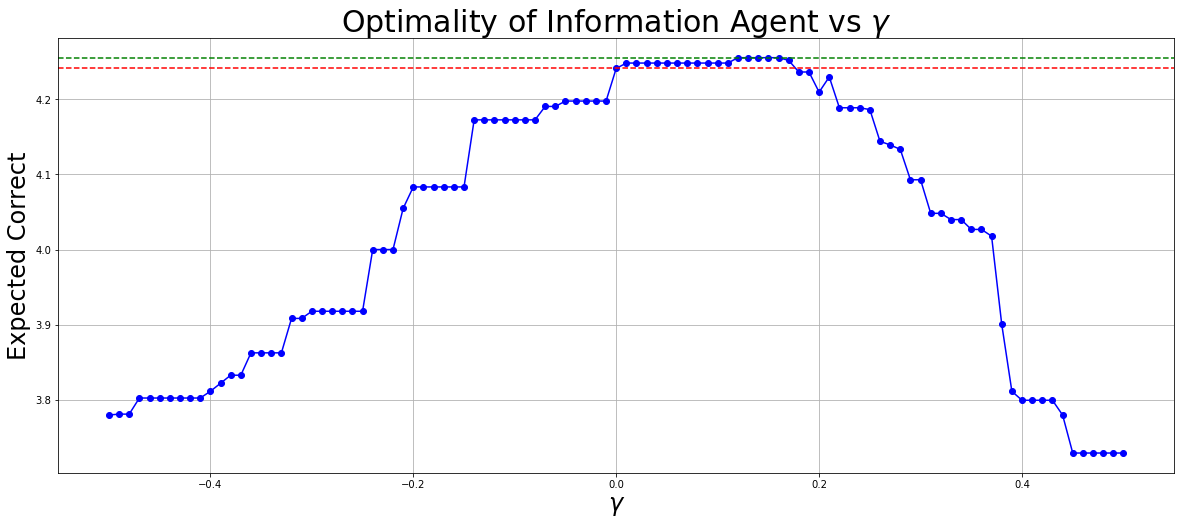

In [12]:
plt.figure(figsize=(20,8))
plt.plot(sweep_vars, sweep_evs, 'bo-')
plt.axhline(y=greedy_ev, color='r', linestyle='dashed')
plt.axhline(y=opt_ev, color='g', linestyle='dashed')
plt.title(r'Optimality of Information Agent vs $\gamma$', fontsize=30)
plt.xlabel(r'$\gamma$', fontsize=24)
plt.ylabel('Expected Correct', fontsize=24)
plt.grid()
plt.show()

## Sweep of all initial deck compositions from (1,0,0,0) to (4,4,4,4)
This code takes a while to run (up to a day on a reasonably fast computer).

In [52]:
initials = []
for i0 in range(4+1):
    for i1 in range(i0+1):
        for i2 in range(i1+1):
            for i3 in range(i2+1):
                initials.append((i0,i1,i2,i3))
initials = initials[1:]
print('Number of composite vectors:', len(initials))

results = {'Initial':[], 'Time':[], 'Greedy':[], 'InfoV1':[], 'Optimal':[]}
for initial in initials:
    t0 = time.time()
    
    results['Initial'].append(initial)
    print(initial)
    
    ev = GreedyAgent(initial=initial).ev()
    results['Greedy'].append(ev)
    print(' >  Greedy: %.15f (%s)'%(ev, str(ev)))
    
    ev = InfoAgent(gamma=1e-6, initial=initial).ev()
    results['InfoV1'].append(ev)
    print(' >  InfoV1: %.15f (%s)'%(ev, str(ev)))
    
    ev = OptimalAgent(initial=initial).ev()
    results['Optimal'].append(ev)
    print(' > Optimal: %.15f (%s)'%(ev, str(ev)))
    
    t0 = time.time() - t0
    results['Time'].append(t0)
    print(' > Took %.3f seconds.'%t0)
    
    with open('results.p', 'wb') as f:
        pickle.dump(results, f)
    print()

Number of composite vectors: 69
(1, 0, 0, 0)
 >  Greedy: 1.000000000000000 (1)
 >  InfoV1: 1.000000000000000 (1)
 > Optimal: 1.000000000000000 (1)
 > Took 0.003 seconds.

(1, 1, 0, 0)
 >  Greedy: 1.500000000000000 (3/2)
 >  InfoV1: 1.500000000000000 (3/2)
 > Optimal: 1.500000000000000 (3/2)
 > Took 0.008 seconds.

(1, 1, 1, 0)
 >  Greedy: 1.666666666666667 (5/3)
 >  InfoV1: 1.666666666666667 (5/3)
 > Optimal: 1.666666666666667 (5/3)
 > Took 0.055 seconds.

(1, 1, 1, 1)
 >  Greedy: 1.708333333333333 (41/24)
 >  InfoV1: 1.708333333333333 (41/24)
 > Optimal: 1.708333333333333 (41/24)
 > Took 0.265 seconds.

(2, 0, 0, 0)
 >  Greedy: 2.000000000000000 (2)
 >  InfoV1: 2.000000000000000 (2)
 > Optimal: 2.000000000000000 (2)
 > Took 0.013 seconds.

(2, 1, 0, 0)
 >  Greedy: 2.333333333333333 (7/3)
 >  InfoV1: 2.333333333333333 (7/3)
 > Optimal: 2.333333333333333 (7/3)
 > Took 0.014 seconds.

(2, 1, 1, 0)
 >  Greedy: 2.416666666666667 (29/12)
 >  InfoV1: 2.416666666666667 (29/12)
 > Optimal: 2.4

 > Optimal: 4.844285714285714 (3391/700)
 > Took 291.994 seconds.

(4, 3, 3, 3)
 >  Greedy: 4.849044289044289 (52006/10725)
 >  InfoV1: 4.849593739593740 (1456333/300300)
 > Optimal: 4.876774891774891 (225307/46200)
 > Took 599.308 seconds.

(4, 4, 0, 0)
 >  Greedy: 5.328571428571428 (373/70)
 >  InfoV1: 5.328571428571428 (373/70)
 > Optimal: 5.328571428571428 (373/70)
 > Took 0.070 seconds.

(4, 4, 1, 0)
 >  Greedy: 5.255555555555556 (473/90)
 >  InfoV1: 5.255555555555556 (473/90)
 > Optimal: 5.255555555555556 (473/90)
 > Took 7.529 seconds.

(4, 4, 1, 1)
 >  Greedy: 5.190000000000000 (519/100)
 >  InfoV1: 5.194761904761905 (10909/2100)
 > Optimal: 5.207777777777777 (4687/900)
 > Took 37.611 seconds.

(4, 4, 2, 0)
 >  Greedy: 5.204126984126984 (16393/3150)
 >  InfoV1: 5.208888888888889 (1172/225)
 > Optimal: 5.221904761904762 (5483/1050)
 > Took 22.964 seconds.

(4, 4, 2, 1)
 >  Greedy: 5.158499278499279 (89371/17325)
 >  InfoV1: 5.172005772005772 (17921/3465)
 > Optimal: 5.1905050505

In [13]:
import pandas as pd
with open('results.p', 'rb') as f:
    res = pickle.load(f)
df = pd.DataFrame(res)

In [14]:
df

,Greedy,InfoV1,Initial,Optimal,Time
0,1,1,"(1, 0, 0, 0)",1,0.002532
1,3/2,3/2,"(1, 1, 0, 0)",3/2,0.008157
2,5/3,5/3,"(1, 1, 1, 0)",5/3,0.054776
3,41/24,41/24,"(1, 1, 1, 1)",41/24,0.264952
4,2,2,"(2, 0, 0, 0)",2,0.012598
5,7/3,7/3,"(2, 1, 0, 0)",7/3,0.014356
6,29/12,29/12,"(2, 1, 1, 0)",29/12,0.153736
7,73/30,73/30,"(2, 1, 1, 1)",73/30,0.735306
8,17/6,17/6,"(2, 2, 0, 0)",17/6,0.029589
9,17/6,17/6,"(2, 2, 1, 0)",17/6,0.410274


## Interactive Outreach
Run this cell to set up an interactive game where the CPU agent guesses cards and you respond `y` or `n` to it.

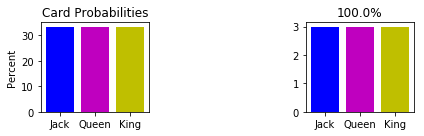

Is it a Jack?
y



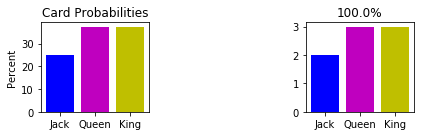

Is it a Queen?
n



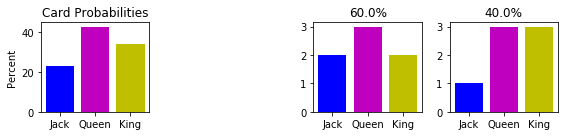

Is it a Queen?
n



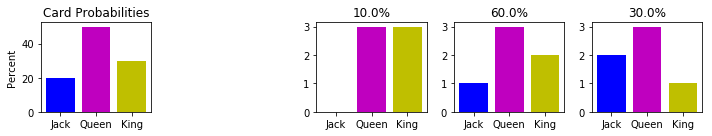

Is it a Queen?
y



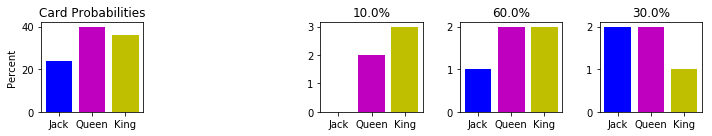

Is it a Queen?
y



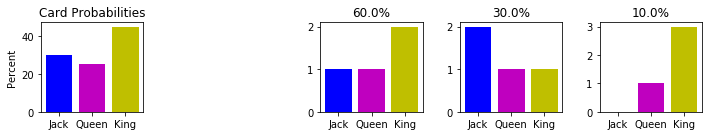

Is it a King?
y



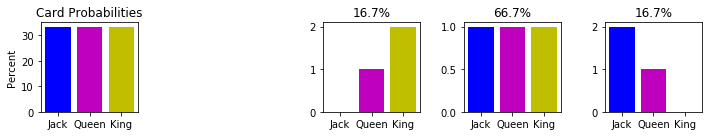

Is it a Queen?
y



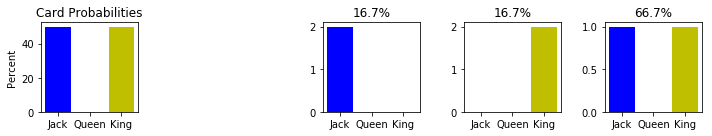

Is it a Jack?
y



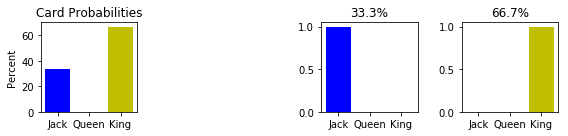

Is it a King?
y

Done. Got 7 correct.


In [15]:
initial = (3,3,3)
card_to_idx = {'j':0, 'q':1, 'k':2, 'a':3}
idx_to_card = ['Jack', 'Queen', 'King', 'Ace']
idx_to_color = ['b', 'm', 'y', 'k']
agent = OptimalAgent(initial=initial)

def print_states(verbose=False):
    if verbose:
        states = '    '.join(['%.1f%%: ['%(100*v) + ' '.join([str(kk) + idx_to_card[i][0] for i,kk in enumerate(k)]) + ']' for k,v in agent.states.iteritems()])
        print('Compositions: ', states)
    
    if verbose:
        gprobs = '    '.join(['%.1f%%: '%(100*v) + idx_to_card[i] for i,v in enumerate(agent.group_prob)])
        print('Group Probabilities: ', gprobs)
        
    nstates = len(agent.states)
    plt.figure(figsize=(2*nstates + 4, 2))
    for i, (state, v) in enumerate(agent.states.iteritems()):
        plt.subplot(1,nstates+2,i+3)
        plt.bar(range(len(initial)), state, width=0.8, tick_label=idx_to_card[:len(initial)], color=idx_to_color[:len(initial)])
        plt.title('%.1f%%'%(100*v))
    
    plt.subplot(1,nstates+2,1)
    plt.bar(range(len(initial)), 100*np.array(agent.group_prob), width=0.8, tick_label=idx_to_card[:len(initial)], color=idx_to_color[:len(initial)])
    plt.ylabel('Percent')
    plt.title('Card Probabilities')
    plt.tight_layout()
    plt.show()

while agent.size > 0:
    print_states()
    try:
        guess = agent.make_guess()
    except Exception as e:
        print('Haha. Nice try. Those responses are impossible...')
        break
    print('Is it a %s?'%idx_to_card[guess])
    correct = raw_input()[0].lower() == 'y'
    agent.update_state(guess, correct)
    print()
print('Done. Got %d correct.'%agent.correct)

## Records
Records the results from our outreach event.

In [16]:
# (3, 3, 3)
results = [
    ('s0', 5, 2),
    ('s1', 3, 3),
    ('s2', 5, 4),
    ('s3', 3, 4),
    ('s4', 0, 5),
    ('s5', 2, 3),
    ('s6', 6, 5),
    ('s7', 3, 6),
    ('s8', 2, 3),
]
results = [e for e in results if len(e) > 1]
names, human, cpu = zip(*results)
df = pd.DataFrame(OrderedDict([('Name',names), ('Human',human), ('CPU',cpu)]))
hs = np.mean(df['Human'])
cs = np.mean(df['CPU'])
print('Humans: %.3f | CPU: %.3f | Compare: %+.3f%%'%(hs, cs, -100*(1-hs/cs)))
df

Humans: 3.222 | CPU: 3.889 | Compare: -17.143%


,Name,Human,CPU
0,s0,5,2
1,s1,3,3
2,s2,5,4
3,s3,3,4
4,s4,0,5
5,s5,2,3
6,s6,6,5
7,s7,3,6
8,s8,2,3
